In [14]:
import os
import cv2
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from tensorflow.keras import Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, add, GRU
from tensorflow.keras.callbacks import ModelCheckpoint

%matplotlib inline

In [2]:
train_dir = 'train'
val_dir = 'val'

def process_img(x):
    return 1 - cv2.cvtColor(x, cv2.COLOR_BGR2GRAY)

def open_img(x, dir):
    return mpimg.imread(os.path.join(dir, x))


2200
fpp8b.png
(47, 195, 3)


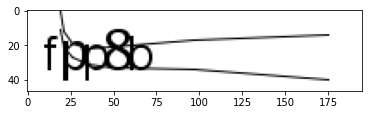

In [3]:
files = list(filter(lambda x: '.png' in x, os.listdir(train_dir)))
print(len(files))
sample = np.random.choice(files)
print(sample)
img = mpimg.imread('train/' + sample)
plt.imshow(img)
print(img.shape)

In [4]:
x_train = [process_img(open_img(file, train_dir)) for file in os.listdir(train_dir)]
#x_val = [process_img(open_img(file, val_dir)) for file in os.listdir(val_dir)]

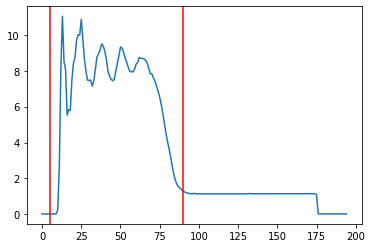

In [5]:
sums = [np.sum(xi, axis=0) for xi in x_train]
means = np.mean(sums, axis =0)
plt.plot(means)
plt.axvline(5,color='r')
plt.axvline(90,color='r')

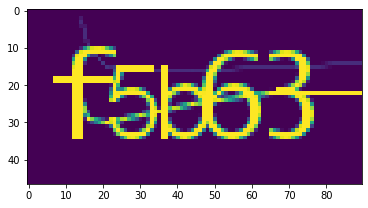

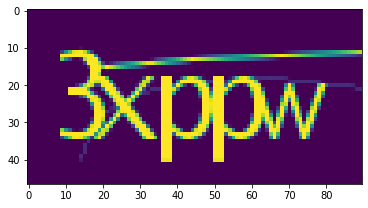

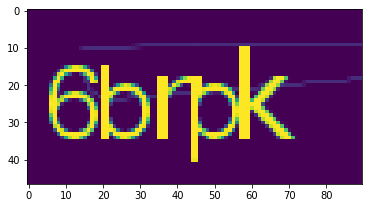

In [6]:
for i in range(3):
    plt.figure()
    sample = np.random.choice(range(2000))
    plt.imshow(x_train[i][:,5:95])

In [7]:
x_train = [np.array(xi[:,5:95]).reshape(47,90,1) for xi in x_train]
#x_val = [np.array(xi[:,5:95]).reshape(47,90,1) for xi in x_val]

In [8]:
unique_tokens = [set(x.split('.')[0]) for x in filter(lambda x: '.png' in x, os.listdir('train'))]
tokens = set()
for t in unique_tokens:
    tokens = tokens.union(t)
n_tokens = len(tokens)
dic = {t:i for i,t in enumerate(tokens)}
inv = {i:t for i,t in enumerate(tokens)}

len(tokens)

24

In [9]:
def label(dir, n_tokens=len(tokens)):
    y = []
    for f in list(filter(lambda x: '.png' in x, os.listdir(dir))):
        f = f.split('.')[0]
        y_ = np.zeros([5, n_tokens])

        for i in range(5):
            y_[i][dic[f[i]]] = 1
        y.append(np.array(y_).reshape(5,n_tokens))
    return y

y_train = label(train_dir)
#y_val = label(val_dir)

f5b63


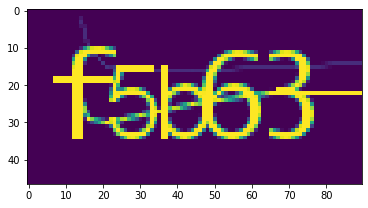

In [10]:
plt.imshow(x_train[0])

label = np.argmax(y_train[0], axis = 1)
l = ''
for e in label:
    l += inv[e]
print(l)

3xppw


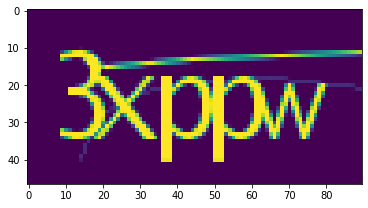

In [42]:
plt.imshow(x_val[0])

label = np.argmax(y_val[0], axis = 1)
l = ''
for e in label:
    l += inv[e]
print(l)

In [16]:
h, w = 47, 90

reg_val = .002

input_layer = Input(shape=(h, w, 1))
x = Conv2D(64, 4, activation='relu', kernel_regularizer=l2(reg_val), bias_regularizer=l2(reg_val))(input_layer)
x = MaxPooling2D((2,2))(x)
x = Conv2D(64, 4, activation='relu', kernel_regularizer=l2(reg_val), bias_regularizer=l2(reg_val))(x)
x = MaxPooling2D((2,2))(x)

x = Reshape(target_shape=(5,-1))(x)
x = Dense(5, activation='swish', kernel_regularizer=l2(reg_val), bias_regularizer=l2(reg_val))(x)

fw = GRU(128, return_sequences=True, kernel_initializer='he_normal', kernel_regularizer=l2(reg_val), bias_regularizer=l2(reg_val))(x)
bw = GRU(128, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', kernel_regularizer=l2(reg_val), bias_regularizer=l2(reg_val))(x)

bgru = add([fw, bw])
output = Dense(n_tokens, activation='softmax')(bgru)


clf = Model(inputs=input_layer, outputs=output)
clf.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 47, 90, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 44, 87, 64)   1088        input_2[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 22, 43, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 19, 40, 64)   65600       max_pooling2d_2[0][0]            
_______________________________________________________________________________________

In [17]:
clf.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model_checkpoint_callback = ModelCheckpoint(
    filepath='model',
    save_weights_only=True,
    monitor='val_loss',
    mode='max',
    save_best_only=True)

h = clf.fit(np.array(x_train), np.array(y_train), 
            validation_split=100/2000,
            #validation_data=(np.array(x_val), np.array(y_val)), 
            epochs=200, batch_size=512, callbacks=[model_checkpoint_callback])

Epoch 1/200
5/5 [==============================] - 8s 2s/step - loss: 6.4072 - accuracy: 0.0410 - val_loss: 6.3551 - val_accuracy: 0.0436
Epoch 2/200
5/5 [==============================] - 7s 1s/step - loss: 6.3313 - accuracy: 0.0464 - val_loss: 6.2850 - val_accuracy: 0.0436
Epoch 3/200
5/5 [==============================] - 7s 1s/step - loss: 6.2652 - accuracy: 0.0564 - val_loss: 6.2231 - val_accuracy: 0.0564
Epoch 4/200
5/5 [==============================] - 7s 1s/step - loss: 6.1997 - accuracy: 0.0569 - val_loss: 6.1630 - val_accuracy: 0.0545
Epoch 5/200
5/5 [==============================] - 7s 1s/step - loss: 6.1420 - accuracy: 0.0655 - val_loss: 6.1134 - val_accuracy: 0.0364
Epoch 6/200
5/5 [==============================] - 7s 1s/step - loss: 6.0849 - accuracy: 0.0649 - val_loss: 6.0547 - val_accuracy: 0.0473
Epoch 7/200
5/5 [==============================] - 7s 1s/step - loss: 6.0275 - accuracy: 0.0718 - val_loss: 6.0057 - val_accuracy: 0.0455
Epoch 8/200
5/5 [=================

5/5 [==============================] - 6s 1s/step - loss: 3.1990 - accuracy: 0.4721 - val_loss: 3.4125 - val_accuracy: 0.3982
Epoch 61/200
5/5 [==============================] - 6s 1s/step - loss: 3.1556 - accuracy: 0.4805 - val_loss: 3.4028 - val_accuracy: 0.3982
Epoch 62/200
5/5 [==============================] - 6s 1s/step - loss: 3.1249 - accuracy: 0.4828 - val_loss: 3.3468 - val_accuracy: 0.4091
Epoch 63/200
5/5 [==============================] - 6s 1s/step - loss: 3.0826 - accuracy: 0.4949 - val_loss: 3.3078 - val_accuracy: 0.4218
Epoch 64/200
5/5 [==============================] - 6s 1s/step - loss: 3.0455 - accuracy: 0.5049 - val_loss: 3.3360 - val_accuracy: 0.3964
Epoch 65/200
5/5 [==============================] - 7s 1s/step - loss: 3.0272 - accuracy: 0.5011 - val_loss: 3.2870 - val_accuracy: 0.4036
Epoch 66/200
5/5 [==============================] - 6s 1s/step - loss: 3.0004 - accuracy: 0.5038 - val_loss: 3.2490 - val_accuracy: 0.4055
Epoch 67/200
5/5 [======================

Epoch 119/200
5/5 [==============================] - 6s 1s/step - loss: 1.7973 - accuracy: 0.7290 - val_loss: 2.4239 - val_accuracy: 0.5109
Epoch 120/200
5/5 [==============================] - 6s 1s/step - loss: 1.7837 - accuracy: 0.7307 - val_loss: 2.4570 - val_accuracy: 0.4982
Epoch 121/200
5/5 [==============================] - 6s 1s/step - loss: 1.7802 - accuracy: 0.7216 - val_loss: 2.3975 - val_accuracy: 0.5055
Epoch 122/200
5/5 [==============================] - 6s 1s/step - loss: 1.7593 - accuracy: 0.7318 - val_loss: 2.4200 - val_accuracy: 0.5018
Epoch 123/200
5/5 [==============================] - 6s 1s/step - loss: 1.7531 - accuracy: 0.7337 - val_loss: 2.4210 - val_accuracy: 0.5091
Epoch 124/200
5/5 [==============================] - 6s 1s/step - loss: 1.7332 - accuracy: 0.7388 - val_loss: 2.3892 - val_accuracy: 0.5164
Epoch 125/200
5/5 [==============================] - 6s 1s/step - loss: 1.7167 - accuracy: 0.7402 - val_loss: 2.3988 - val_accuracy: 0.5255
Epoch 126/200
5/5 [=

5/5 [==============================] - 6s 1s/step - loss: 1.1522 - accuracy: 0.8556 - val_loss: 2.1346 - val_accuracy: 0.5418
Epoch 178/200
5/5 [==============================] - 6s 1s/step - loss: 1.1369 - accuracy: 0.8593 - val_loss: 2.1406 - val_accuracy: 0.5382
Epoch 179/200
5/5 [==============================] - 6s 1s/step - loss: 1.1368 - accuracy: 0.8601 - val_loss: 2.1307 - val_accuracy: 0.5527
Epoch 180/200
5/5 [==============================] - 6s 1s/step - loss: 1.1324 - accuracy: 0.8571 - val_loss: 2.1415 - val_accuracy: 0.5473
Epoch 181/200
5/5 [==============================] - 6s 1s/step - loss: 1.1394 - accuracy: 0.8533 - val_loss: 2.1859 - val_accuracy: 0.5345
Epoch 182/200
5/5 [==============================] - 6s 1s/step - loss: 1.1316 - accuracy: 0.8509 - val_loss: 2.1412 - val_accuracy: 0.5400
Epoch 183/200
5/5 [==============================] - 6s 1s/step - loss: 1.1328 - accuracy: 0.8482 - val_loss: 2.1148 - val_accuracy: 0.5509
Epoch 184/200
5/5 [===============

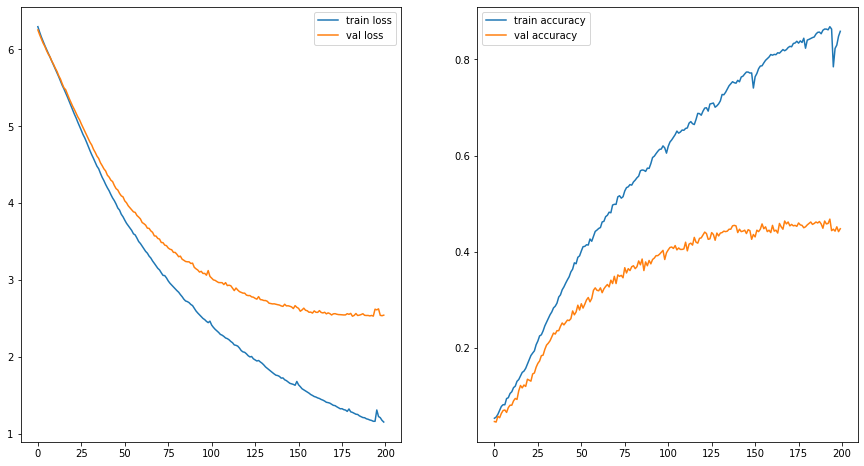

In [50]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
ax1.plot(h.history['loss'], label='train loss')
ax1.plot(h.history['val_loss'], label='val loss')
ax1.legend()

ax2.plot(h.history['accuracy'], label='train accuracy')
ax2.plot(h.history['val_accuracy'], label='val accuracy')
ax2.legend()